In [1]:
# importing libraries
import numpy as np
import random
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Importing visualisation libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from progressbar import ProgressBar

# NLP libraries
from bs4 import BeautifulSoup
import re
import nltk
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Classifier libraries
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Neural Network Libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Loading train and validation datasets
df_tweets = pd.read_csv('./datasets/df_tweets.csv', index_col=0)

In [ ]:
df_tweets = df_tweets[df_tweets['cleaned_tweets'].notnull()]

In [ ]:
# Creating a new column to count the len of string
df_tweets['string_count'] = df_tweets['cleaned_tweets'].map(lambda row: len(str(row)))

# Creating a new column to count the number of words
df_tweets['word_count'] = df_tweets['cleaned_tweets'].map(lambda row: len(str(row).split()))

# Adding number of unique words column
df_tweets['unique_words_count'] = df_tweets['cleaned_tweets'].map(lambda x: len(list(str(x).split())))

# as well as the type of unique words
df_tweets['unique_words'] = df_tweets['cleaned_tweets'].map(lambda x: list(str(x).split()))

# Creating a new column to count the len of string
df_tweets['string_count'] = df_tweets['cleaned_tweets'].map(lambda row: len(str(row)))

# Creating a new column to count the number of words
df_tweets['word_count'] = df_tweets['cleaned_tweets'].map(lambda row: len(str(row).split()))

In [ ]:
df_tweets.drop(['difference', 'date', 'tweet_day', 'unique_words','content'],axis=1, inplace=True)

In [ ]:
df_tweets.shape

In [2]:
# Loading train and validation datasets
y_train = pd.read_csv('./datasets/y_train.csv', index_col=0)
y_validate = pd.read_csv('./datasets/y_validate.csv', index_col=0)

X_train = pd.read_csv('./datasets/X_train.csv', index_col=0)
X_validate = pd.read_csv('./datasets/X_validate.csv', index_col=0)

# Train Validation and Holdout Data

## Holdout Data

In [ ]:
X = df_tweets.drop('target', axis=1)
y = df_tweets['target']

In [ ]:
# Holdout data split
X_train_validate, X_holdout, y_train_validate, y_holdout = train_test_split(X,y,test_size=0.15, shuffle=False)

In [ ]:
X_holdout.tail()

In [ ]:
X_holdout.shape

In [ ]:
X_train_validate.shape

## Train and Validation

In [ ]:
df_train_validate = X_train_validate.join(y_train_validate)

In [ ]:
df_train_validate.columns

In [ ]:
X = df_train_validate.drop(['target'], axis=1)
y = df_train_validate['target']

In [ ]:
# Train and validate data split
X_train, X_validate, y_train, y_validate = train_test_split(X,y,test_size=0.15, shuffle=False)

In [ ]:
X_train.tail()

In [ ]:
X_train.shape

# Classifier 3: Recurrent Neural Networks (LSTM)

### gs5 tokenize->Timeseries->NN

In [4]:
# Extract the X and y values from the train and validation set
X_train_list = X_train['cleaned_tweets'].values
X_val_list = X_validate['cleaned_tweets'].values

y_train_list = y_train.values
y_val_list = y_validate.values

In [5]:
max_words = 2000 # Note: Model tends to overfit when max_words is set to 2000-3000 words

# Tokenize the data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(X_train_list))

# Convert the text to sequences
X_train_list = tokenizer.texts_to_sequences(X_train_list)
X_val_list = tokenizer.texts_to_sequences(X_val_list)

In [6]:
vocab_size = len(tokenizer.word_index)+1
print('Vocabulary size:', vocab_size)

Vocabulary size: 26952


Add padding to ensure that all the sequences have the same shape. As the average length of a negative review is 15 words and a positive review is 7 words, we will set a max length of 20.

In [7]:
max_length = 30 

X_train_padded = pad_sequences(X_train_list, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_list, maxlen=max_length, padding='post')

In [8]:
y_train_list.shape

(27671, 1)

In [9]:
X_train_padded.shape

(27671, 30)

Next, we will create the network topology. The training data is fed to a three-layered neural network. The first layer is a Bidirectional LSTM with 8 nodes. The second layer is a dense layer with 8 nodes and the output layer with just one node.

In [15]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=20, input_length=max_length))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics= ['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 20)            539040    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                6560      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 546,679
Trainable params: 546,679
Non-trainable params: 0
________________________________________________

In [18]:
%%time
# Fit the model and store it in the history object
history = model.fit(X_train_padded, y_train_list, epochs=40, batch_size=64, validation_data=(X_val_padded, y_val_list))

Train on 27671 samples, validate on 6918 samples
Epoch 1/40
27671/27671 [==============================] - 7s 260us/sample - loss: 0.4539 - accuracy: 0.8455 - val_loss: 0.4293 - val_accuracy: 0.8463
Epoch 2/40
27671/27671 [==============================] - 5s 177us/sample - loss: 0.4177 - accuracy: 0.8463 - val_loss: 0.4283 - val_accuracy: 0.8463
Epoch 3/40
27671/27671 [==============================] - 5s 180us/sample - loss: 0.4031 - accuracy: 0.8466 - val_loss: 0.4353 - val_accuracy: 0.8458
Epoch 4/40
27671/27671 [==============================] - 5s 176us/sample - loss: 0.3912 - accuracy: 0.8492 - val_loss: 0.4463 - val_accuracy: 0.8439
Epoch 5/40
27671/27671 [==============================] - 5s 177us/sample - loss: 0.3769 - accuracy: 0.8518 - val_loss: 0.4493 - val_accuracy: 0.8401
Epoch 6/40
27671/27671 [==============================] - 5s 179us/sample - loss: 0.3629 - accuracy: 0.8572 - val_loss: 0.4655 - val_accuracy: 0.8325
Epoch 7/40
27671/27671 [===========================

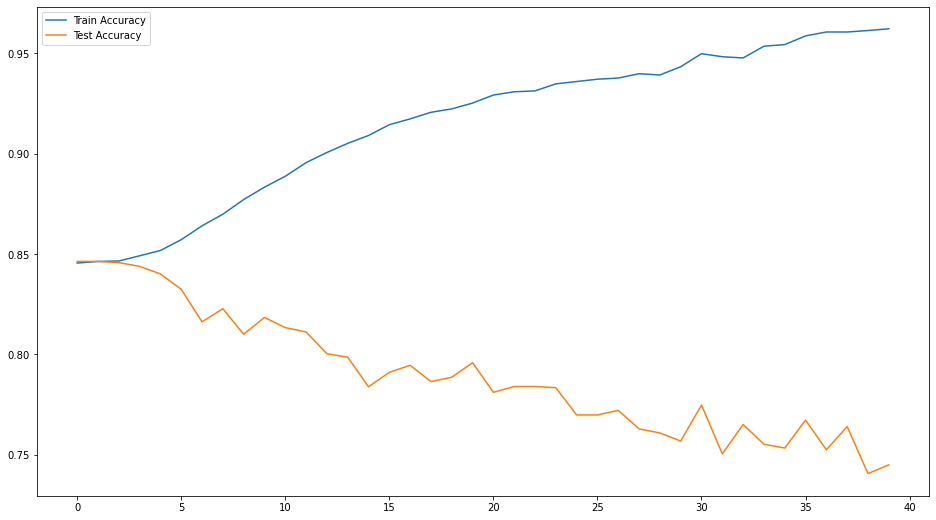

In [19]:
plt.figure(figsize=(16,9))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend();